## Quantum State Tomography (QST)


QST reconstrcut the $n$-qubit density matrix $\rho$ as,
$$
\rho=\frac{1}{2^n} \sum_{i, j,\ldots \ell=0}^3 c_{i j \ldots \ell} \sigma_i^{(1)} \otimes \sigma_j^{(2)} \ldots \otimes \sigma_\ell^{(n)},
$$
where $c_{i j \ldots \ell} \in \mathbb{C}$ and each $\sigma \in \{\sigma_x, \sigma_y, \sigma_z\}$.
Here, we demonstrate how to briefly use `qiskit-experiments` package to implement QST with  and without measurement error mitigation.
For more details about API and the package itself, please refer to [here](https://qiskit-community.github.io/qiskit-experiments/manuals/verification/state_tomography.html).

### Setup the backend

In [ ]:
%%capture
from qiskit_ibm_runtime import QiskitRuntimeService

# Get a real backend from the runtime service
service = QiskitRuntimeService('YOUR_API_TOKEN')

device = service.backend('ibm_fez')

If you don't have access to the hardware, please use the following fake backend that mimics the real hardware with past calibration data.

In [1]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeFez

noiseless_backend = AerSimulator()  # if don't want hardware noise
backend = AerSimulator.from_backend(FakeFez())

### Circuit construction

In this tutorial, we will use the `RealAmplitudes` ansatz that consists of layers of $R_y$ rotation gates and adjacent CNOT gates.

In [2]:
import dill as pickle

# Load pre-generated parameters
with open('params.pkl', 'rb') as f:
    loaded_param = pickle.load(f)

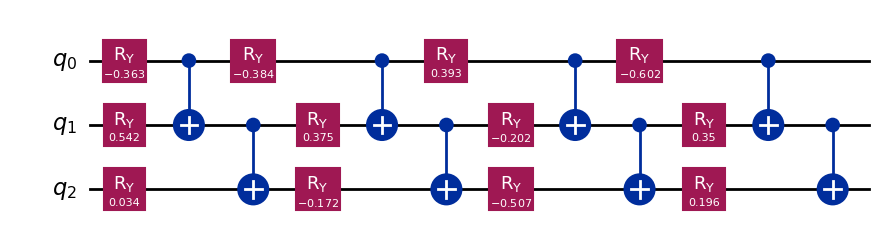

In [3]:
from qiskit.circuit.library import RealAmplitudes

num_qubits = 3
num_layers = 4
ansatz = RealAmplitudes(num_qubits, entanglement='pairwise', reps=num_layers, skip_final_rotation_layer=True)
params = loaded_param['parameter'][(num_qubits, num_layers)][0]  # contains 5 groups of parameters
ansatz.assign_parameters(params, inplace=True)
ansatz.decompose().draw("mpl")

### QST without error mitigation

In [5]:
from qiskit_experiments.library import StateTomography

# Set number of experiment shots
shots = 10000

# QST Experiment
qstexp = StateTomography(ansatz)     #! DO NOT Transpile the circuit here
qstexp.set_run_options(shots=shots)
qstdata = qstexp.run(backend, seed_simulation=999).block_for_results()

# Turn on 'physical_qubits' to force the qubit mapping
# qstdata = qstexp.run(backend, physical_qubits=[141,142,143],seed_simulation=999).block_for_results()

In [ ]:
# Fidelity of state reconstruction
fid_result = qstdata.analysis_results("state_fidelity", dataframe=True).iloc[0]
print("State Fidelity = {:.5f}".format(fid_result.value))

In [ ]:
# Visualize the state
from qiskit.visualization import plot_state_city

state = qstdata.analysis_results("state", dataframe=True).iloc[0].value
plot_state_city(state, title='Density Matrix')

### QST with error mitigation

The measurement error mitigation is realized through `mthree` calibrations. Read [here](https://qiskit.github.io/qiskit-addon-mthree/) for more details.

In [ ]:
from qiskit_experiments.library import MitigatedStateTomography

# Set number of experiment shots
shots = 10000

# Error Mitigated QST Experiment
mitqstexp = MitigatedStateTomography(ansatz)
mitqstexp.set_run_options(shots=shots)
mitqstdata = mitqstexp.run(backend, seed_simulation=999).block_for_results()

In [ ]:
# Fidelity of error mitigated state reconstruction
mit_fid_result = mitqstdata.analysis_results("state_fidelity", dataframe=True).iloc[0]
print("State Fidelity (mitigated) = {:.5f}".format(mit_fid_result.value))
print("State Fidelity (raw) = {:.5f}".format(fid_result.value))

In [ ]:
# Visualize the state
from qiskit.visualization import plot_state_city

mit_state = mitqstdata.analysis_results("state", dataframe=True).iloc[0].value
plot_state_city(mit_state, title='Error Mitigated Density Matrix')

### Runtime scaling

---


## Software info

In [4]:
import qiskit
import qiskit_aer
import qiskit_ibm_runtime
import qiskit_experiments

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit Aer: {qiskit_aer.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
print(f'Qiskit Experiments: {qiskit_experiments.__version__}')

Qiskit: 2.0.0
Qiskit Aer: 0.17.0
Qiskit IBM Runtime: 0.38.0
Qiskit Experiments: 0.10.0
